In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.special import factorial
import sympy as sp

In [8]:
def first_digit(number):
    # Convert the number to a string
    number_str = str(number)
    
    # Check if the string is not empty
    if number_str:
        # Return the first character (first digit)
        return int(number_str[0])
    else:
        # Handle the case where the input is empty
        return None
    
def first_digit_of_power_of_two(i):
    return first_digit(2**i)

for i in range(1000):
    result = first_digit_of_power_of_two(i)
    if result == 9:
        print(i)

53
63
73
83
93
156
166
176
186
249
259
269
279
289
352
362
372
382
445
455
465
475
485
548
558
568
578
641
651
661
671
734
744
754
764
774
837
847
857
867
930
940
950
960
970


In [9]:
2**53

9007199254740992

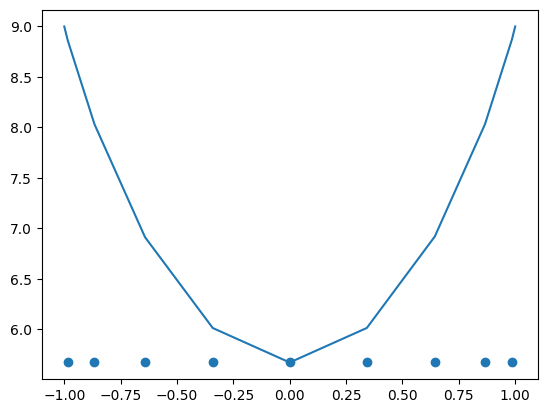

In [10]:

def abss(x, k):

    pr = Performative_Regression(k=k, n=1000, T=1, sigma=1, M=np.sqrt(2))

    s = 0
    for i in range(k+1):
        s += np.abs(x - pr.thetas[i])

    return s

k = 8
pr = Performative_Regression(k=k, n=1000, T=1, sigma=1, M=np.sqrt(2))
t = np.linspace(-1, 1, 1000)

plt.plot(t, abss(t, k))
plt.scatter(pr.thetas, abss(0, k)*np.ones(len(pr.thetas)))
plt.show()


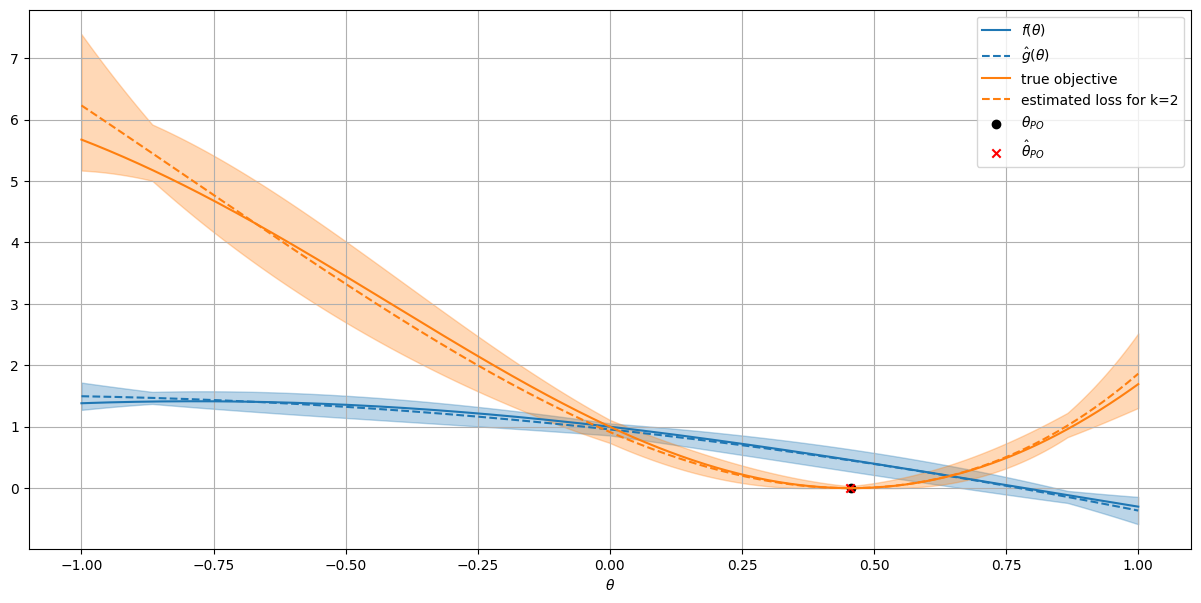

In [11]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=1, M=1):
        """
        Parameters:
        - k (int): Polynomial degree.
        - n (int): Number of samples for each theta_i.
        - T (float): Total number of rounds, should be > kn.
        - sigma (float, optional): Standard deviation of the noise. Default is 1.
        - M (float, optional): Bound of the derivatives of f. Default is 1.
        """
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.M = M

        # Produce k+1 Chebyshev nodes
        self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))

        self.f_hat_values = self.f_hat()
               
    def f(self, theta):
        """
        Computes the true function value at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The function value at the specified theta.
        """

        fun = np.cos(theta) - np.sin(theta)
        #fun = np.e**theta + 1
        
        return fun
    
    def f_hat(self):
        """
        Generates the array of noisy function values at the Chebyshev nodes.

        Returns:
        - numpy.ndarray: Array with element i equal to f_hat(theta_i) where theta_i is the ith Chebyshev node.
        """
        
        Y = (
            np.repeat(self.f(self.thetas)[:, np.newaxis], self.n, axis=1) +
            np.random.normal(0, self.sigma, (self.k+1, self.n))
        )

        f_hat = np.mean(Y, axis=1)

        return f_hat

    def vandermonde_matrix(self):
        """
        Computes the Vandermonde matrix with Chebyshev nodes.

        Returns:
        - numpy.ndarray: The Vandermonde matrix.
        """

        return np.vander(self.thetas, increasing=True)

    def vandermonde_determinant(self):
        """
        Computes the determinant of the Vandermonde matrix.

        Returns:
        - float: The determinant of the Vandermonde matrix.
        """

        det = (-1)**((self.k+1) * self.k / 2 ) * ((self.k+1)**(self.k+1) / 2**(self.k*self.k))**(1/2)
        
        return det   
    
    def true_loss(self, theta):
        """
        Computes the true objective function at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The true objective function evaluated at theta.
        """

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def g_hat(self, theta):
        """
        Computes the estimated g_hat at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated function value at the specified theta.
        """
        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            p_theta = p_theta + prod * self.f_hat_values[i]
        
        return p_theta

    def estimated_loss(self, theta):
        """
        Computes the estimated objective function value at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated objective function value at the specified theta.
        """

        g_estimate = self.g_hat(theta)

        return g_estimate**2 - 2 * theta * g_estimate + theta**2

    def optimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.min(g_values**2 - 2 * theta * g_values + theta**2, axis=0)
    
    def pessimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.max(g_values**2 - 2 * theta * g_values + theta**2, axis=0)

    def remainder(self, theta):
        """
        Computes the upper bound of the absolute value of the remainder term for a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The upper bound of the absolute value of the remainder term at the specified theta.
        """

        cheb_polynomial = np.cos((self.k+1)*np.arccos(theta))/(2**(self.k))

        return self.M * np.abs(cheb_polynomial) / math.factorial(self.k + 1)

    def lagrange_bound(self, theta):
        """
        Computes the sum of the absolute value of the Lagrange polynomials.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The sum of the absolute value of the Lagrange polynomials.
        """

        sum_new = 0
        for i in range(self.k+1):
            sum_new += np.abs(
                np.sin(np.pi * (2*i + 1) / (2*self.k + 2)) * np.cos((self.k+1)*np.arccos(theta)) / (self.k+1) / (theta - np.cos(np.pi * (2*i + 1) / (2*self.k + 2)))
            )

        return sum_new
    
    def conf_interval_at_theta(self, theta):

        """
        Computes the confidence interval at a theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The confidence interval at the specified theta.
        """
        B_1 = self.remainder(theta)
        B_2 = self.lagrange_bound(theta) * 1.96 * self.sigma / np.sqrt(self.n)
        
        return B_1 + B_2

    def minimum(self):

        t = np.linspace(-1, 1, 10000)
        gs = self.estimated_loss(t)
        fs = self.true_loss(t)
        estimated_min = t[np.argmin(gs)]
        true_min = t[np.argmin(fs)]
        return estimated_min, true_min

    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 1000)
        
        plt.plot(t, self.f(t), 'C0', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'C0--', label=r"$\hat{g}(\theta)$")
        plt.fill_between(t,
                         self.g_hat(t) - self.conf_interval_at_theta(t),
                         self.g_hat(t) + self.conf_interval_at_theta(t),
                         alpha=0.3,
                         color="C0")
    
    def plot_objectives(self):
        
        t = np.linspace(-1, 1, 1000)
        ci = self.conf_interval_at_theta(t)
        ci_2 = ci**2 + 2 * ci * (self.g_hat(t) - t)
        ci_3 = ci**2 - 2 * ci * (self.g_hat(t) - t)
        plt.plot(t, self.true_loss(t), 'C1', label='true objective')
        plt.plot(t, self.estimated_loss(t), 'C1--', label=f'estimated loss for k={self.k}')
        plt.fill_between(t,
                         self.optimistic_loss(t),
                         self.pessimistic_loss(t),
                         alpha=0.3,
                         color='C1')

        estimated_min = self.minimum()[0]
        true_min = self.minimum()[1]
        plt.scatter(true_min, self.true_loss(true_min), label=r'$\theta_{PO}$', color='k')
        plt.scatter(estimated_min, self.true_loss(estimated_min), label=r'$\hat{\theta}_{PO}$', marker='x', color='r')
        plt.xlabel(r"$\theta$")

pr = Performative_Regression(k=2, n=100, T=1, sigma=0.5, M=np.sqrt(2))
plt.figure(figsize=(15, 7))
pr.plot_f_vs_g()
pr.plot_objectives()
plt.grid()
plt.legend()
plt.show()

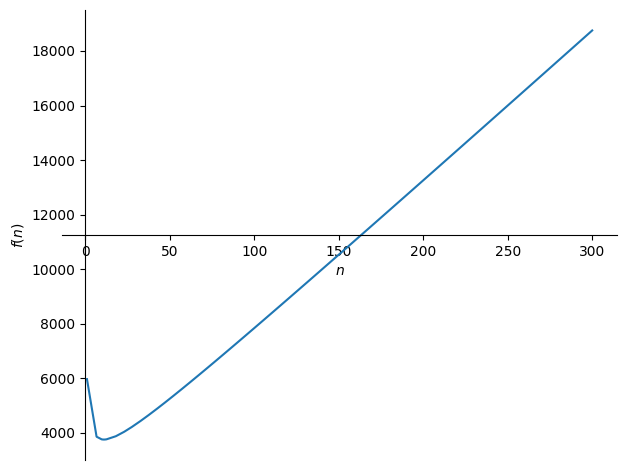

In [28]:
k = sp.symbols("k")
n = sp.symbols("n")
L = 1
T = 1000
k = 3

b = 1.96 / sp.sqrt(n) +1 / (2**k * sp.factorial(k+1))
R = 4 * n * (k+1) * (L + 1)**2 +  (T - n * (k + 1)) * (0*b**2 + 2* b * L + 2)

%matplotlib inline
sp.plot(R, (n, 1, 300))
plt.show()

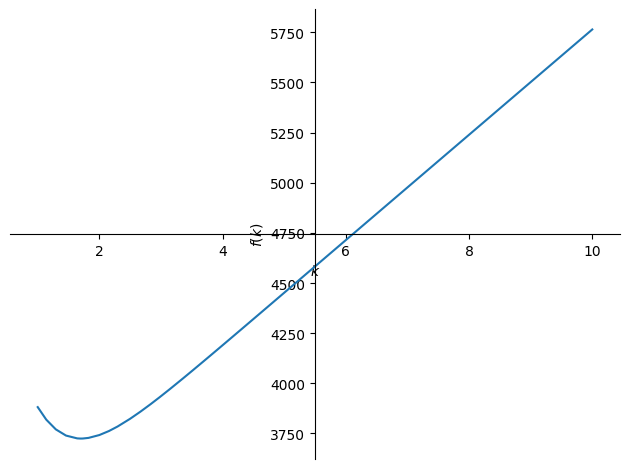

In [40]:
k = sp.symbols("k")
n = sp.symbols("n")
L = 1
T = 1000
n = 20

b = 1.96 / sp.sqrt(n) +1 / (2**k * sp.factorial(k+1))
R = 4 * n * (k+1) * (L + 1)**2 +  (T - n * (k + 1)) * (0*b**2 + 2* b * L + 2)

%matplotlib inline
sp.plot(R, (k, 1, 10))
plt.show()

In [49]:
k = sp.symbols("k")
n = sp.symbols("n")
L = 1
T = sp.symbols("T")

b = 1.96 / sp.sqrt(n) +1 / (2**k * sp.factorial(k+1))
R = 4 * n * (k+1) * (L + 1)**2 +  (T - n * (k + 1)) * (1*b**2 + 2* b * L + 2)

sp.diff(R, n)

16*k + (T - n*(k + 1))*(-3.8416*(1/sqrt(n) + 0.510204081632653/(2**k*factorial(k + 1)))/n**(3/2) - 1.96/n**(3/2)) + (-k - 1)*(3.8416*(1/sqrt(n) + 0.510204081632653/(2**k*factorial(k + 1)))**2 + 2 + 3.92/sqrt(n) + 2/(2**k*factorial(k + 1))) + 16

In [48]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

def regret(k, n):
    T = 10000
    L = 1

    # Use element-wise operations for arrays
    b = 1 / (2**k * factorial(k+1)) + 1.96 / np.sqrt(n)

    # Element-wise calculations for arrays
    R =  4* n * (k + 1) * (L + 1)**2 + (T - n * (k + 1)) * (1*b**2 + 2 * b * L + 2)

    return R

# Define the range of k and n values
k_values = np.arange(1, 10, 1)
n_values = np.arange(1, 1000, 1)

# Create a meshgrid for k and n
k_mesh, n_mesh = np.meshgrid(k_values, n_values)
k_mesh = k_mesh.astype(int)
n_mesh = n_mesh.astype(int)

# Calculate regret for each combination of k and n
regret_values = regret(k_mesh, n_mesh)

min_indices = np.unravel_index(np.argmin(regret_values, axis=None), regret_values.shape)
a = k_values[min_indices[1]]
b = n_values[min_indices[0]]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(k_mesh, n_mesh, regret_values)

# Add labels and a colorbar
ax.set_xlabel('k')
ax.set_ylabel('n')
ax.set_zlabel('Regret')
fig.colorbar(surface, label='Regret')
ax.scatter(a, b, regret(a, b), color='r', alpha=1)
# Show the plot
plt.show()